# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры, влияющие на эту стоимость. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


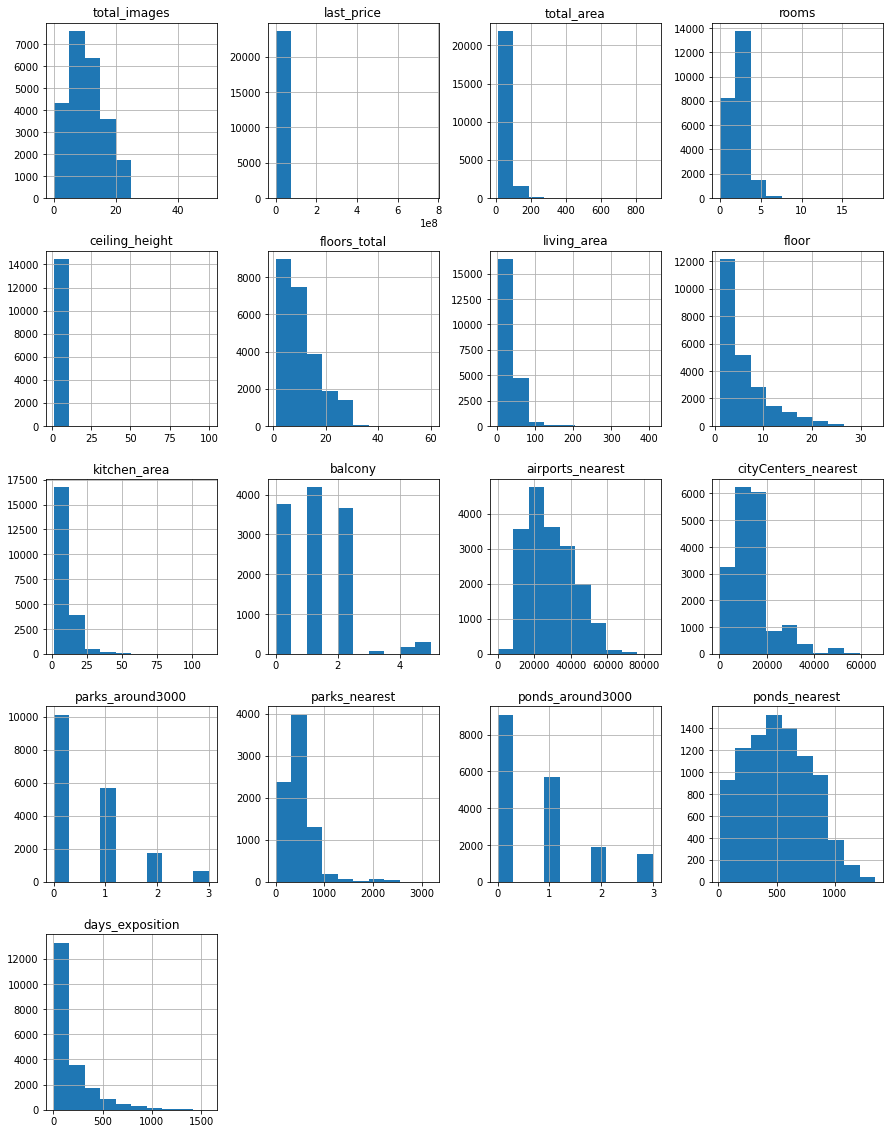

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t') 
print(data.info())
display(data.head())
data.hist(figsize=(15, 20));

В файле таблица с данными по объявлениям о продаже объектов недвижимости. Примерно 24 тысячи строк, 22 столбца, есть пропуски.

### Предобработка данных

#### Обработка пропусков

In [4]:
data.isna().sum() #до заполнения

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пользовательские данные пропущены в столбцах *'balcony', 'ceiling_height', 'living_area', 'kitchen_area', 'is_apartment', 'floors_total'*. Эти пропуски могли быть появиться как благодаря человеческому фактору, так и из-за технических ошибок. Значительное количество пропусков есть в столбцах *'balcony'* и *'is_apartment'*, но как раз эти пропуски устранимы. Если бы балконы были, их бы указали, поэтому заменим пропуски на 0. Апартаменты не настолько популярны в РФ, чтобы их было большинство, поэтому пропуск, скорее всего, означает False. Еще есть пропуски в столбце *'locality_name'*, их всего 49 штук, влияния на анализ они не окажут, поэтому удалим их.

In [5]:
data['balcony'] = data['balcony'].fillna('0') 
data['is_apartment'] = data['is_apartment'].fillna(False) 
data = data.dropna(subset = ['locality_name'])

Высота потолков имеет довольно узкий диапазон значений, заменим пропуски на медиану.

In [6]:
ceiling_height_local_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_local_median)

Жилая площадь и площадь кухни зависят от общей площади (в которой нет пропусков). Для заполнения пропусков добавим столбец с медианным отношением жилой площади и площади кухни от общей и получим примерное значение с помощью этого коэффициента.

In [7]:
total_area_local_median = data['total_area'].median()
kitchen_area_local_median = data['kitchen_area'].median()
living_area_local_median = data['living_area'].median()
data['kitchen_total_factor'] = kitchen_area_local_median/total_area_local_median# медианная доля площади кухни от общей площади
data['living_total_factor'] = living_area_local_median/total_area_local_median# медианная доля жилой площади от общей площади

data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*data['kitchen_total_factor'])
data['living_area'] = data['living_area'].fillna(data['total_area']*data['living_total_factor'])

In [8]:
data.isna().sum() 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               85
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
kitchen_total_factor        0
living_total_factor         0
dtype: int64

Остались пропуски (85 шт) в пользовательском столбце *'floors_total'*. Эта величина дискретная и зависит от типа конкретного дома, а дома бывают очень разными даже в одном районе. Оставим пропуски, как есть, в дальнейшем анализе ни они сами, ни тип ячеек не помешает.
Пропуски в картографических данных также оставляем, потому что эти величины могут сильно отличаться в зависимости от географического положения дома.

#### Типы данных

In [9]:
data['balcony'] = pd.to_numeric(data['balcony']).astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
#оставляем только дату, точность до часов не нужна

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

Несоответствия с типом данных есть в столбцах: *'balcony'* (количество балконов должно быть выражено числом), *'first_day_exposition'* (должно быть дата/время).

#### Дубликаты в названиях

In [10]:
#функция для определения типа населенного пункта
def locality_type_definer (row):
    if 'поселок' in str(row):
        return 'поселок'
    elif 'деревня' in str(row):
        return 'деревня'
    elif 'село' in str(row):
        return 'село'
    elif 'сад' in str(row):
        return 'садовое товарищество'
    else:
        return 'город'

#посмотрим, сколько есть уникальных названий 
print('Количество уникальных названий', len( data['locality_name'].unique()))

#убираем лишние слова в разнообразных поселках
data['locality_name'] = data['locality_name'].str.replace('ё','е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок поселок','поселок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок','поселок')

#добавляем столбец с типом населенного пункта
data['locality_type'] = data['locality_name'].apply(locality_type_definer)

#смотрим, сколько каких
for loc_type in data['locality_type'].unique():
    print('Строк с типом населенного пункта', loc_type, 
          len((data.loc[data['locality_type']==loc_type]['locality_name'].unique())))
    
#display(sorted(data.loc[data['locality_type']=='деревня']['locality_name'].unique()) )
#вывод все еще довольно громоздкий, поэтому он закомменчен. 
#использован display, а не print из-за удобной формы вывода столбцом

#на вид совпадений в названиях между разными населенными пунктами нет, но все же проверим, например
for name in data.loc[data['locality_type']=='город']['locality_name'].unique():
    if name in data.loc[data['locality_type']!='город']['locality_name'].unique():
        print('совпадения есть')
#совпадений нет

#Убедимся, что уникальных названий стало меньше
print('Количество уникальных названий стало', len(data['locality_name'].unique()))

Количество уникальных названий 364
Строк с типом населенного пункта город 43
Строк с типом населенного пункта поселок 158
Строк с типом населенного пункта деревня 106
Строк с типом населенного пункта садовое товарищество 5
Строк с типом населенного пункта село 9
Количество уникальных названий стало 321


Искать неявные дубликаты в общем списке было сложно (там было 365 уникальных значения), поэтому данные были категоризированы по типу населенного пункта. Внутри категории, особенно отсортированной, уже было несложно заметить неявные дубликаты - 'поселок', 'посёлок городского типа' и т.д. с одинаковыми названиями. Уникальных названий стало меньше, потому что исправлены ячейки с неявными дубликатами.

#### Выбивающиеся значения

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

Выбросы могут быть только в столбцах с количественными данными. Рассмотрим их все по очереди.

##### Площадь и стоимость

Средняя площадь объектов с менее чем 25 изображениями - 60
Средняя площадь объектов с более чем 25 изображениями - 92


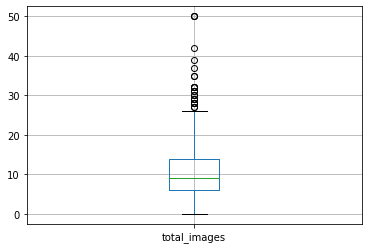

In [12]:
data.boxplot(column = 'total_images')
print('Средняя площадь объектов с менее чем 25 изображениями -', data[data['total_images']<25]['total_area'].mean().astype(int))
print('Средняя площадь объектов с более чем 25 изображениями -', data[data['total_images']>25]['total_area'].mean().astype(int))

Максимальное значение количества фотографий 50 не похоже на ошибку ввода, это может быть, например, квартира большой площади или с замысловатым дизайнерским ремонтом: чтобы ее показать, может быть нужно много изображений. Чтобы убедиться в этом, посчитаем среднюю площадь объектов с количеством изображений больше 25. Получилось 92 квадратных метра, довольно много. Для сравнения средняя площадь остальных квартир - 60 метров, в полтора раза меньше. Значит, большие значения здесь это не аномалии.

329
4240


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
12971,19,763000000.0,400.0,2017-09-30,7,2.65,10.0,250.0,10,False,...,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0,0.175,0.576923,город


8793      12190.0
17456    430000.0
14911    430000.0
16274    440000.0
17676    450000.0
Name: last_price, dtype: float64

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,...,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0,0.175,0.576923,город


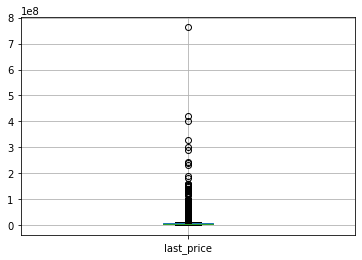

In [13]:
data.boxplot(column = 'last_price')
print(data[data['last_price']>100000000]['total_area'].mean().astype(int))#средняя площадь дорогих квартир
print(data[data['last_price']>100000000]['cityCenters_nearest'].mean().astype(int))#их средняя близость к центру
display(data[data['last_price']>500000000])#самая дорогая
display(data['last_price'].sort_values().head(5))
display(data.query('last_price < 100000'))
data ['last_price'] = data['last_price'].replace(12190.0, 12190000.0)

Похожая картина - есть довольно много объектов, выбивающихся по стоимости. И снова возьмем объекты дороже 100 млн рублей, их средняя площадь уже 329 метров, а средняя близость к центру - 4км, это большие квартиры рядом с центром, понятно, почему они такие дорогие. Единственная квартира, которая вызывает сомнения, - с самой высокой стоимостью (763млн). Это, конечно, может быть вполне настоящая стоимость, но есть несколько но:
1. Запрос на Яндекс.Недвижимость сейчас показывает несколько квартир около 500 млн, но ни одной настолько дорогой;
2. Она почти в два раза дороже ближайшей меньшей и может искажать статистику;
3. Сочетание параметров площади и расположения не соответствуют настолько высокой стоимости - она не такая уж большая по сравнению с соседями и не так уж близка к центру. 

Пока оставим ее, но в дальнейшем, возможно, придется убрать ее из рассмотрения.

Посмотрим на 5 самых дешевых объектов: 430 тыс.руб. вполне реальная стоимость маленькой комнаты в области, а вот за 12190 невозможно купить недвижимость. Выведем всю строку: 109 квадратов, 25 этаж, 9 км до центра, это точно не 12 тысяч. Скорее всего, ошибка на три нуля, то есть реальная стоимость 12 миллионов, а не тысяч.


19904    12.0
19807    13.0
17961    13.0
19546    13.0
19558    13.2
Name: total_area, dtype: float64
Средняя стоимость квартир площадью больше 400 -  127426057


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,False,...,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,0.175,0.576923,город


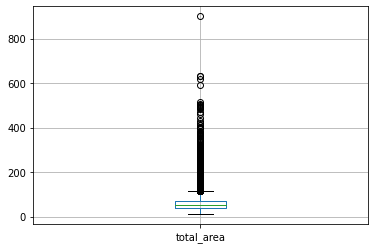

In [14]:
data.boxplot(column = 'total_area')
#убедимся, что крайние снизу значения не слишком низки
print(data['total_area'].sort_values().head())
#в 12 метрах вполне можно жить
print('Средняя стоимость квартир площадью больше 400 - ',
      data[data['total_area']>400]['last_price'].mean().astype(int))#средняя стоимость больших квартир
data[data['total_area']>800]#посмотрим на самую большую

То же самое - за пределами оказались большие и, соответственно, дорогие (127млн в среднем) квартиры. Площадь больше 700 метров это редкость, но и сейчас на Яндекс.Недвижимости есть пара таких объектов. Это не аномалии, оставляем их.

##### Комнаты

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
14498,6,32250000.0,374.6,2018-06-09,19,2.65,5.0,264.5,2,False,...,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0,0.175,0.576923,город
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4.0,180.0,4,False,...,23575.0,4142.0,1.0,516.0,0.0,NaN,1365.0,0.175,0.576923,город


Количество квартир с 0 комнат - 197
Средняя площадь квартир с 0 комнат - 29
Наибольшая площадь квартир с 0 комнат - 371


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
19392,5,71000000.0,371.0,2018-07-26,0,3.57,7.0,214.038462,6,False,...,25257.0,6060.0,1.0,761.0,1.0,584.0,90.0,0.175,0.576923,город


1     8232
2     7924
3     5797
4     1175
5      326
6      105
7       59
8       12
9        8
10       3
11       2
14       2
16       1
19       1
12       1
15       1
Name: rooms, dtype: int64

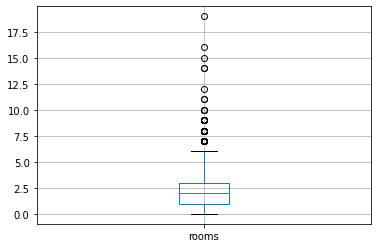

In [15]:
data.boxplot(column = 'rooms')
#print(data['rooms'].value_counts())
display(data[data['rooms']>15])#квартиры с более чем 15 комнатами
print('Количество квартир с 0 комнат -', data[data['rooms']<1]['total_area'].count())
print('Средняя площадь квартир с 0 комнат -',data[data['rooms']<1]['total_area'].mean().astype(int))
print('Наибольшая площадь квартир с 0 комнат -',data[data['rooms']<1]['total_area'].max().astype(int))
display(data.query('rooms==0 and total_area>100'))
data = data.drop(index = [19392]).reset_index(drop=True)
data['rooms'] = data['rooms'].replace(0, 1)
data['rooms'].value_counts()#убедимся, что лишних значений нет

Есть несколько квартир с более чем 10 комнатами. Посмотрим на пару самых многокомнатных - большие площади, высокие стоимости, это нормально. Но есть 197 квартир, у которых указано количество комнат 0, это не может быть правдой. Найдем среднюю площадь таких квартир, 29 квадратных метров. Вроде немного, но максимальное значение площади - 371м, то есть просто сказать, что в этих квартирах 1 комната, нельзя. Выберем из них те, чья площадь более 100 м - всего одна строка с этой самой квартирой 371м, это выброс, его удалим, а у остальных количество комнат изменим на 1.

##### Высота потолков

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
22821,0,15000000.0,25.0,2018-07-25,1,100.0,5.0,14.0,5,True,...,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,0.175,0.576923,город


27.0    8
25.0    7
32.0    2
14.0    1
20.0    1
24.0    1
27.5    1
10.3    1
8.3     1
22.6    1
26.0    1
Name: ceiling_height, dtype: int64
2.00    11
2.20     1
1.75     1
1.20     1
2.25     1
1.00     1
Name: ceiling_height, dtype: int64
Самые высокие потолки - 8.0
Самые низкие потолки - 2.3


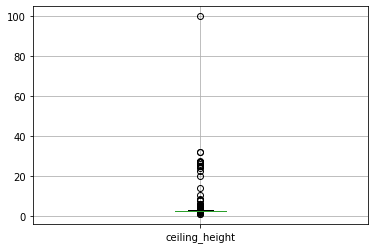

In [16]:
data.boxplot(column = 'ceiling_height')
display(data[data['ceiling_height']>80])#посмотрим, что это за квартира
data = data[data['ceiling_height']!=100]#убираем только одну строку со значением 100м
print(data[data['ceiling_height']>8]['ceiling_height'].value_counts())
print(data[data['ceiling_height']<2.3]['ceiling_height'].value_counts())#посмотрим, какие еще есть значения
data['ceiling_height'] = data['ceiling_height'].replace({27.0:2.7, 25.0:2.5, 32.0:3.2, 24.0:2.4, 26.0:2.6, 27.5:2.75})
wrong_ceiling_heights = [1.0, 1.2, 1.75, 2.0, 2.2, 2.25, 8.3, 10.3, 14.0, 20.0, 22.6]
data = data.query('(ceiling_height not in @wrong_ceiling_heights) or (ceiling_height.isna())')
print('Самые высокие потолки -', data['ceiling_height'].max())
print('Самые низкие потолки -', data['ceiling_height'].min())

Вот тут что-то явно не так. Поиск в интернете говорит, что потолки до 8 метров - это настоящее явление, но все, что больше 8, надо или исправить, или убрать из рассмотрения. Самое большое значение (100м) идет в комплекте с довольно безумным набором - 1 комната, 5 балконов, 15 млн, убираем. Из оставшихся значений те, в которых можно предположить ошибку на порядок, заменяем на нормальные, остальные выбрасываем.

##### Этажей в доме

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
2251,12,3800000.0,45.5,2018-06-28,2,2.88,60.0,27.4,4,False,...,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0,0.175,0.576923,город
16701,9,3978000.0,40.0,2018-09-24,1,2.65,52.0,10.5,18,False,...,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0,0.175,0.576923,город


<AxesSubplot:>

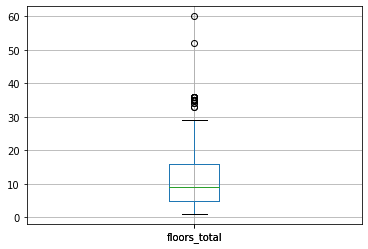

In [17]:
data.boxplot(column = 'floors_total')
display(data[data['floors_total']>40])
data['floors_total'] = data['floors_total'].replace(60, 6)
data = data[data['floors_total']!=52]
data.boxplot(column = 'floors_total')

Поиск в интернете выдает, что самое высокое здание в СПб - Лахта-центр, в нем 88 этажей, но оно не жилое, следующий по высоте - Лидер Тауэр, там 42 этажа. Значит, двое верхних - выбросы. В том, который 60, можно предположить ошибку на порядок, к тому же сама квартира на 4 этаже, небольшой площади, вполне может быть 6-этажное здание. А вот 5,2 этажей не бывает, придется строчку с 52 этажами исключить.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
660,3,49950000.0,483.9,2017-10-04,7,3.20,6.0,312.500000,4,False,...,23079.0,945.0,3.0,461.0,3.0,22.0,391.0,0.175,0.576923,город
3113,19,140000000.0,631.0,2019-03-30,7,2.65,5.0,364.038462,5,False,...,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN,0.175,0.576923,город
4230,1,50000000.0,517.0,2017-10-14,7,2.65,4.0,332.000000,3,False,...,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN,0.175,0.576923,город
5349,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.000000,3,False,...,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0,0.175,0.576923,город
8004,20,84000000.0,507.0,2015-12-17,5,4.45,7.0,301.500000,7,True,...,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0,0.175,0.576923,город
12382,20,91500000.0,495.0,2017-06-19,7,4.65,7.0,347.500000,7,False,...,NaN,5735.0,2.0,110.0,0.0,NaN,14.0,0.175,0.576923,город
12840,20,140000000.0,631.2,2019-04-09,7,3.90,4.0,322.300000,4,False,...,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN,0.175,0.576923,город
19504,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.700000,25,False,...,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,0.175,0.576923,город


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
3238,7,4440000.0,41.0,2017-07-02,1,2.65,17.0,3.000000,17,False,...,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0,0.175,0.576923,город
13892,20,6350000.0,52.0,2018-02-06,2,3.00,6.0,2.000000,2,False,...,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0,0.175,0.576923,город
16404,13,3799000.0,31.0,2018-04-12,1,2.60,5.0,6.000000,1,False,...,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0,0.175,0.576923,город
17551,11,2680000.0,22.0,2018-08-11,1,2.65,25.0,5.000000,8,False,...,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0,0.175,0.576923,город
17929,3,1400000.0,13.0,2017-12-03,1,2.60,9.0,7.500000,1,False,...,14350.0,15945.0,0.0,NaN,1.0,185.0,410.0,0.175,0.576923,город
19216,19,4050000.0,33.0,2018-10-15,1,2.50,22.0,6.500000,21,False,...,9258.0,10592.0,1.0,458.0,0.0,NaN,44.0,0.175,0.576923,город
19510,3,1850000.0,13.0,2019-03-11,1,3.40,5.0,7.500000,2,False,...,24915.0,5483.0,1.0,644.0,0.0,NaN,24.0,0.175,0.576923,город
19522,2,1686000.0,13.2,2018-12-17,1,2.65,5.0,7.615385,1,False,...,19891.0,4165.0,1.0,361.0,1.0,155.0,19.0,0.175,0.576923,город
21713,0,2330000.0,23.0,2018-01-01,1,2.65,24.0,2.000000,22,False,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,0.175,0.576923,поселок
21897,15,6100000.0,77.6,2019-02-28,4,2.50,9.0,5.400000,1,False,...,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0,0.175,0.576923,город


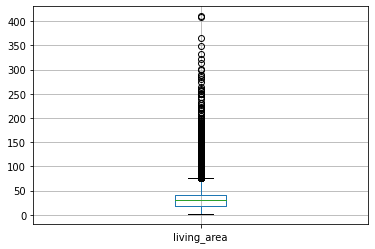

In [18]:
data.boxplot(column = 'living_area')

#посмотрим на квартриры с самой большой жилой площадью
display(data[data['living_area']>300])

#посмотрим на хвост минимальных площадей
display(data[data['living_area']<8])

#исправим площади, где это возможно
data['living_area'] = data['living_area'].replace({2.0 : 20, 3.0 : 30, 5.4 : 54})

#удалим то, что невозможно исправить
data = data.query('living_area > 6 or living_area.isna()')

Выглядит нормально, но все же посмотрим на квартиры с жилой площадью больше 300 квадратов. Большие общие площади, высокая стоимость, действительно нормально. С другим концом распределения сложнее: санитарная норма жилой площади на человека - 6 квадратов. Глядя на список квартир с жилой площадью менее 7 кв.м, можно предположить, что в большинстве случаев произошла ошибка на порядок: в квартире общей площадью 77 кв.м. жилая скорее 54, а не 5.4. Исправим, что возможно, остальное удалим.  

##### Этаж

Самый высокий этаж - 33
Самый низкий этаж - 1


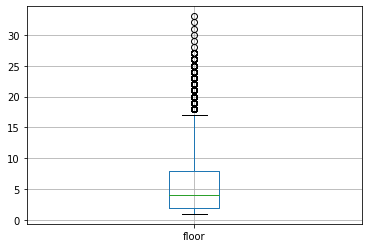

In [19]:
data.boxplot(column = 'floor')
print('Самый высокий этаж -',data['floor'].max())
print('Самый низкий этаж -',data['floor'].min())

Тоже нормально. Самый высокий этаж - 33, а, например, в ЖК «Князь Александр Невский» 37 этажей. Этажей ниже 1 не наблюдается.

##### Площадь кухни

,last_price,total_area,kitchen_area
2487,12500000.0,255.0,100.7000
5349,65000000.0,590.0,100.0000
9809,43185328.0,494.1,86.4675
10849,56844500.0,177.9,87.2000
14991,150000000.0,500.0,87.5000
16212,82400000.0,181.1,93.2000
16767,65850000.0,146.0,93.0000
19504,420000000.0,900.0,112.0000
20177,85000000.0,249.7,107.0000


Самая большая кухня - 112.0


,last_price,total_area,kitchen_area
716,1500000.0,17.00,2.97500
906,2600000.0,27.00,2.00000
1193,2520000.0,22.70,3.97250
1573,2200000.0,22.00,3.85000
1587,1900000.0,21.89,3.83075
...,...,...,...
21757,1737000.0,17.78,3.11150
21935,2000000.0,21.57,3.77475
22310,2050000.0,17.20,3.01000
23142,1900000.0,18.90,3.30750


Самая маленькая кухня - 1.3


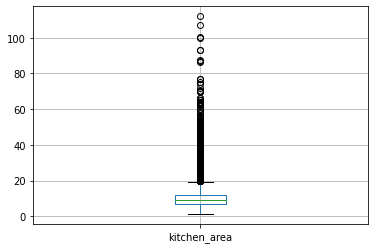

In [20]:
data.boxplot(column = 'kitchen_area')

display(data[data['kitchen_area']>80][['last_price','total_area','kitchen_area']])#посмотрим на самые большие кухни
print('Самая большая кухня -',data['kitchen_area'].max())
display(data[data['kitchen_area']<4][['last_price', 'total_area', 'kitchen_area']])#посмотрим на самые маленькие кухни
print('Самая маленькая кухня -',data['kitchen_area'].min())

Ярких выбросов нет. С экстремально маленькими кухнями (до 5 кв.м.) то же самое - это недорогие маленькие квартиры. Это могут быть, например, кухни-ниши. Нормы проектирования, определяющие минимальный размер кухни, появились недавно, а СПб - старый город. На всякий случай посмотрим на квартиры с самыми большими кухнями - убедимся, что общие площади там не меньше. Есть квартиры, где кухня занимает больше половины общей площади, но мало ли какие бывают планировки.

##### Количество балконов

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_total_factor,living_total_factor,locality_type
41,16,7900000.0,74.00,2016-05-04,3,2.65,14.0,59.000000,8,False,...,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0,0.175,0.576923,город
42,13,22000000.0,161.80,2015-07-08,4,2.80,4.0,80.900000,2,False,...,35416.0,30605.0,2.0,47.0,1.0,907.0,987.0,0.175,0.576923,город
116,18,10999000.0,97.20,2017-11-13,3,2.50,16.0,56.076923,16,False,...,19426.0,21138.0,0.0,NaN,2.0,390.0,394.0,0.175,0.576923,город
267,2,14700000.0,120.00,2018-09-07,3,2.75,20.0,63.000000,18,False,...,39204.0,10430.0,2.0,627.0,3.0,77.0,61.0,0.175,0.576923,город
311,20,12500000.0,86.00,2018-10-19,3,2.80,25.0,47.000000,3,False,...,52192.0,15686.0,0.0,NaN,1.0,441.0,NaN,0.175,0.576923,город
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23098,8,5780000.0,55.00,2017-11-23,2,2.55,10.0,28.600000,8,False,...,42447.0,11146.0,1.0,451.0,0.0,NaN,41.0,0.175,0.576923,город
23239,13,7000000.0,88.00,2018-03-02,3,2.50,15.0,54.000000,12,False,...,24501.0,30287.0,1.0,372.0,0.0,NaN,NaN,0.175,0.576923,город
23313,10,4300000.0,52.00,2019-04-21,1,2.70,16.0,28.000000,8,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175,0.576923,поселок
23476,14,5800000.0,60.69,2018-03-13,3,2.50,9.0,39.700000,2,False,...,51239.0,15954.0,0.0,NaN,0.0,NaN,30.0,0.175,0.576923,город


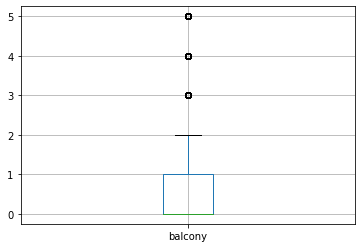

In [21]:
data.boxplot(column = 'balcony')
data[data['balcony']>4]

Выбивающихся значений нет, но данные подозрительные - 1/2/3 комнаты и по 5 балконов.

##### Расстояния до

Расстояния до парков/прудов/аэропортов/центра и количество дней размещения (см. графики внизу) выглядят правдоподобно, аномалий не видно.

<AxesSubplot:>

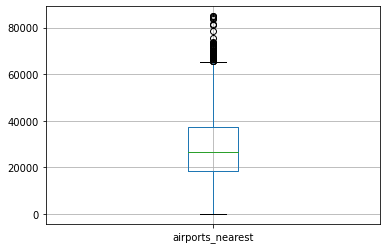

In [22]:
display(data.boxplot(column = 'airports_nearest'))

<AxesSubplot:>

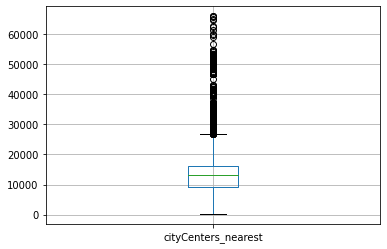

In [23]:
display(data.boxplot(column = 'cityCenters_nearest'))

<AxesSubplot:>

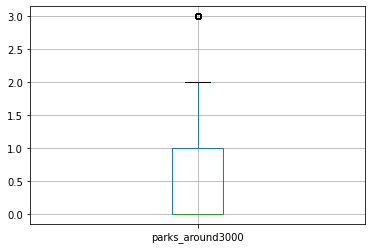

In [24]:
display(data.boxplot(column = 'parks_around3000'))

<AxesSubplot:>

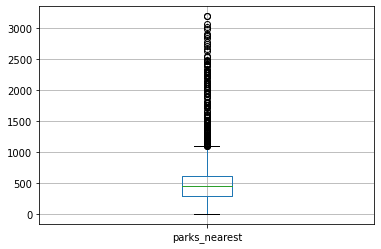

In [25]:
display(data.boxplot(column = 'parks_nearest'))

<AxesSubplot:>

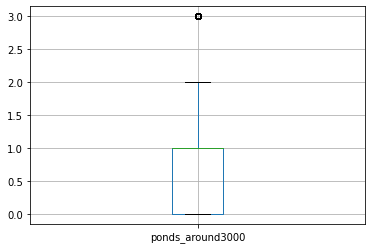

In [26]:
display(data.boxplot(column = 'ponds_around3000'))

<AxesSubplot:>

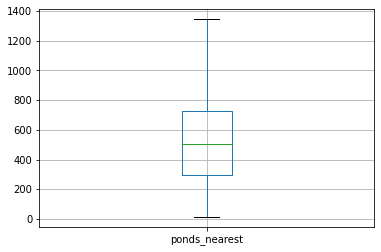

In [27]:
display(data.boxplot(column = 'ponds_nearest'))

<AxesSubplot:>

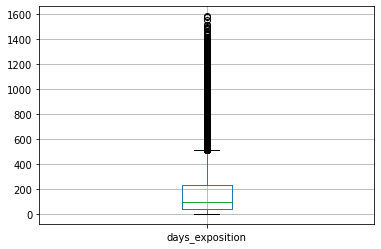

In [28]:
display(data.boxplot(column = 'days_exposition'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23624 entries, 0 to 23648
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23624 non-null  int64         
 1   last_price            23624 non-null  float64       
 2   total_area            23624 non-null  float64       
 3   first_day_exposition  23624 non-null  datetime64[ns]
 4   rooms                 23624 non-null  int64         
 5   ceiling_height        23624 non-null  float64       
 6   floors_total          23539 non-null  float64       
 7   living_area           23624 non-null  float64       
 8   floor                 23624 non-null  int64         
 9   is_apartment          23624 non-null  bool          
 10  studio                23624 non-null  bool          
 11  open_plan             23624 non-null  bool          
 12  kitchen_area          23624 non-null  float64       
 13  balcony         

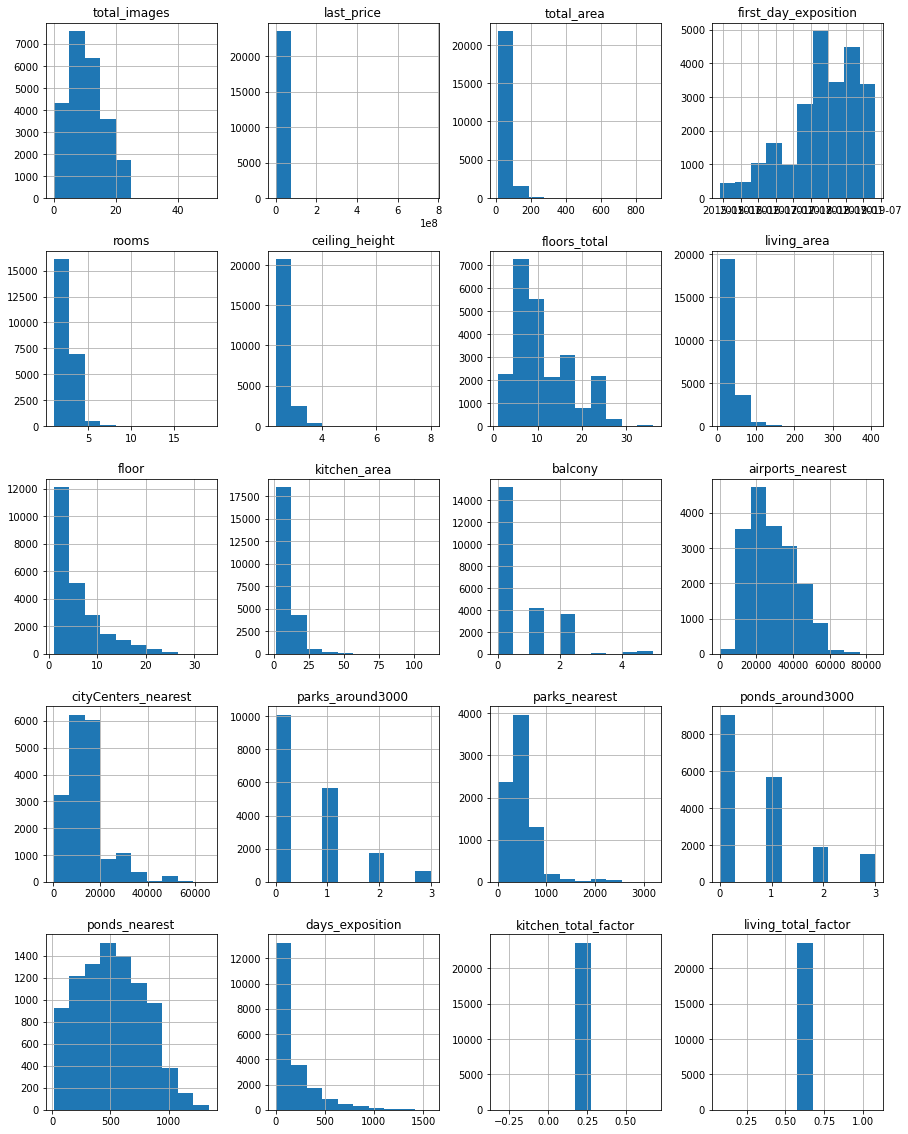

In [29]:
data.info()#посмотрим, как изменился датафрейм
data.hist(figsize=(15, 20));

#### Вывод по предобработке данных

В рамках этого раздела было выполнено следующее:
1. Обработаны пропуски (заменены по возможности).
2. Изменены типы данных, где это было необходимо.
3. Устранены неявные дубликаты в названиях населенных пунктов.
4. Найдены и исправлены при необходимости редкие и выбивающиеся значения.

Всего удалены 75 строк.

### Добавление в таблицу новых столбцов

In [29]:
#функция для определения типа этажа
def floor_type_definer(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    elif row['floor'] == 1:
        return 'первый'
    else:
        return 'другой'
    

data['price_per_sq_meter'] = data['last_price']/data['total_area']#цена за кв. метр
data['weekday_of_exposition'] = data['first_day_exposition'].dt.weekday#день недели публикации
data['month_of_exposition'] = data['first_day_exposition'].dt.month#месяц публикации
data['year_of_exposition'] = data['first_day_exposition'].dt.year#год публикации
data['floor_type'] = data.apply(floor_type_definer, axis = 1)#тип этажа квартиры
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round(0)#расстояние до центра города в километрах
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,kitchen_total_factor,living_total_factor,locality_type,price_per_sq_meter,weekday_of_exposition,month_of_exposition,year_of_exposition,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.000000,8,False,...,NaN,0.175,0.576923,город,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.600000,1,False,...,81.0,0.175,0.576923,поселок,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.300000,4,False,...,558.0,0.175,0.576923,город,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,91.730769,9,False,...,424.0,0.175,0.576923,город,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,False,...,121.0,0.175,0.576923,город,100000.000000,1,6,2018,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.400000,5,False,...,55.0,0.175,0.576923,поселок,95065.789474,0,9,2018,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.600000,6,False,...,155.0,0.175,0.576923,поселок,99195.710456,3,11,2017,другой,19.0
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,41.307692,22,False,...,NaN,0.175,0.576923,город,110544.692737,3,4,2019,другой,12.0
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.430000,26,False,...,189.0,0.175,0.576923,поселок,87454.764777,2,5,2018,другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.600000,7,False,...,289.0,0.175,0.576923,город,88524.590164,6,2,2017,другой,15.0


В таблицу добавлено несколько новых столбцов, которые могут помочь в анализе.

### Исследовательский анализ данных

#### Изучение параметров

In [30]:
data.info()#вспомним, какие вообще есть столбцы

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23624 entries, 0 to 23648
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23624 non-null  int64         
 1   last_price              23624 non-null  float64       
 2   total_area              23624 non-null  float64       
 3   first_day_exposition    23624 non-null  datetime64[ns]
 4   rooms                   23624 non-null  int64         
 5   ceiling_height          23624 non-null  float64       
 6   floors_total            23539 non-null  float64       
 7   living_area             23624 non-null  float64       
 8   floor                   23624 non-null  int64         
 9   is_apartment            23624 non-null  bool          
 10  studio                  23624 non-null  bool          
 11  open_plan               23624 non-null  bool          
 12  kitchen_area            23624 non-null  float6

Разобъем данные на группы по смыслу (цена, геометрические параметры квартиры, дискретные величины, расстояния до, день/месяц) и построим гистограммы для всех. 

count    2.362400e+04
mean     6.541327e+06
std      1.089355e+07
min      4.300000e+05
25%      3.405000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

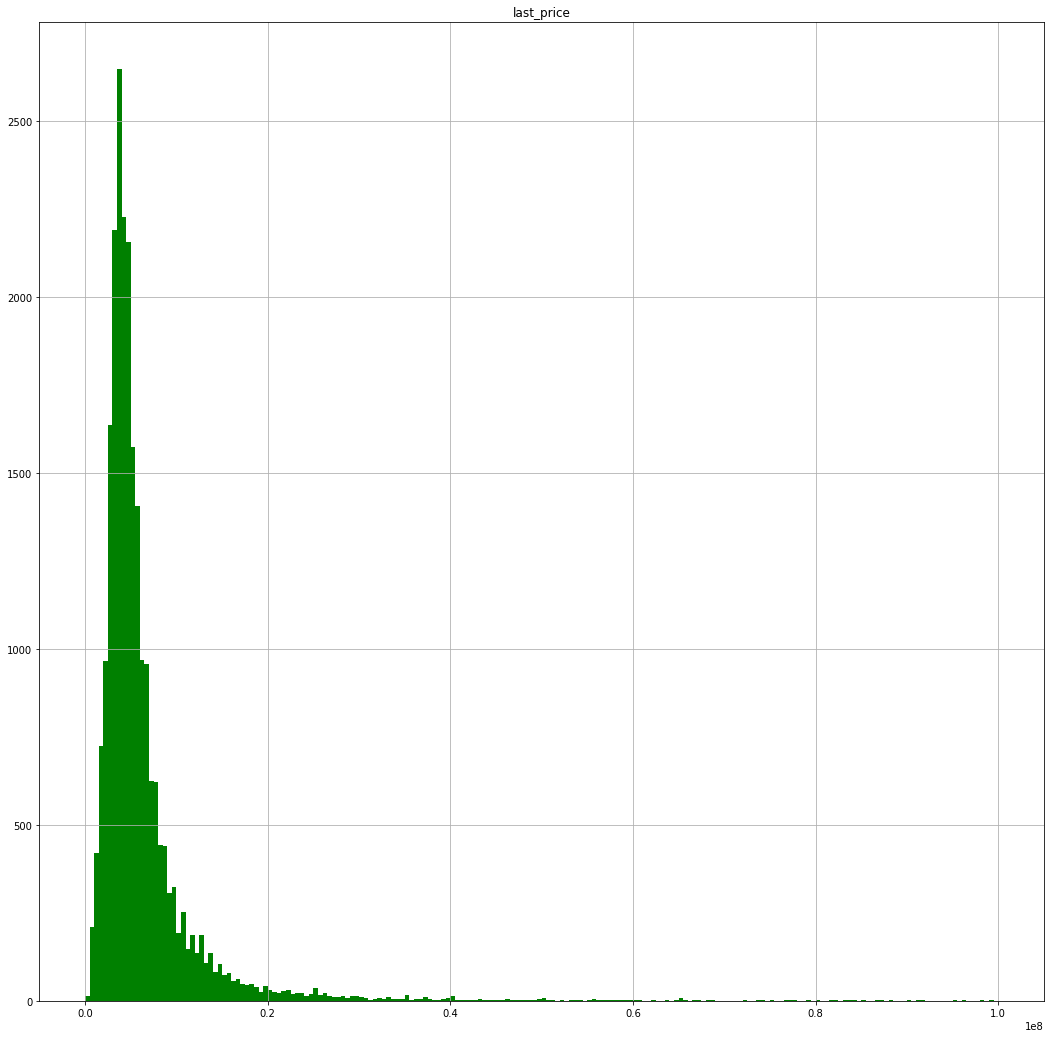

In [31]:
data[['last_price']].hist(figsize=(18, 18), color = 'green', bins = 200, range = (0, 100000000)) ;
#график ограничен сверху по 100млн рублей, чтобы было лучше видно детали в основной части
data['last_price'].describe()

count    23624.000000
mean        60.331187
std         35.616538
min         12.000000
25%         40.000000
50%         52.000000
75%         69.762500
max        900.000000
Name: total_area, dtype: float64

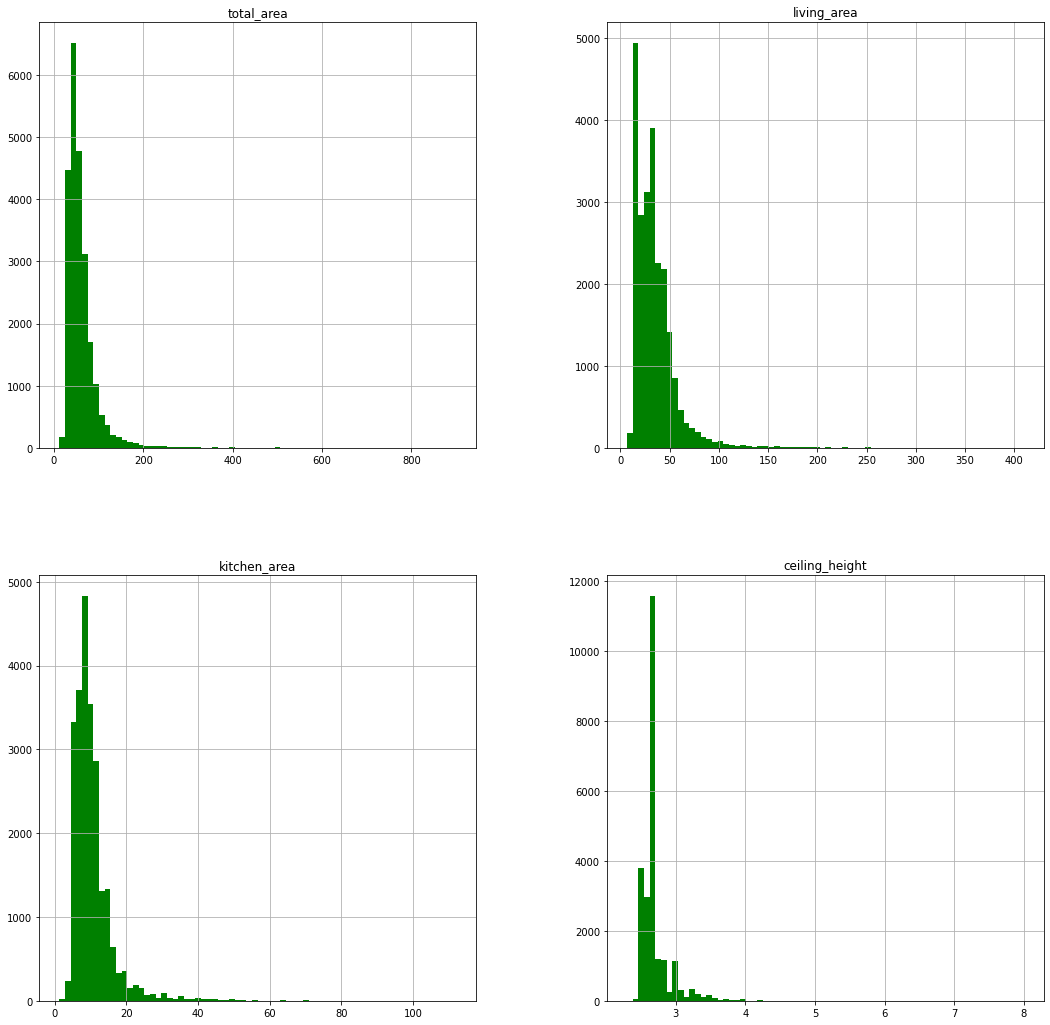

In [30]:
data[['total_area', 'living_area', 'kitchen_area', 'ceiling_height']].hist(figsize=(18, 18), color = 'green', bins = 70) ;
data['total_area'].describe()

Цены и площади распределены по Пуассону. Значительное большинство квартир стоит менее 10млн, имеет площадь менее 100 квадратных метров, жилую менее 50, площадь кухни до 20 метров. Жилая площадь и площадь кухни имеют ярко выраженный пик у среднего значения. Это может быть вызвано в том числе заменой пропусков, но в защиту замены можно сказать, что график общей площади, в котором никаких замен не было, имеет ту же форму. По высоте потолков тоже пик на значении 2.65 м, которым заменялись пропущенные значения.

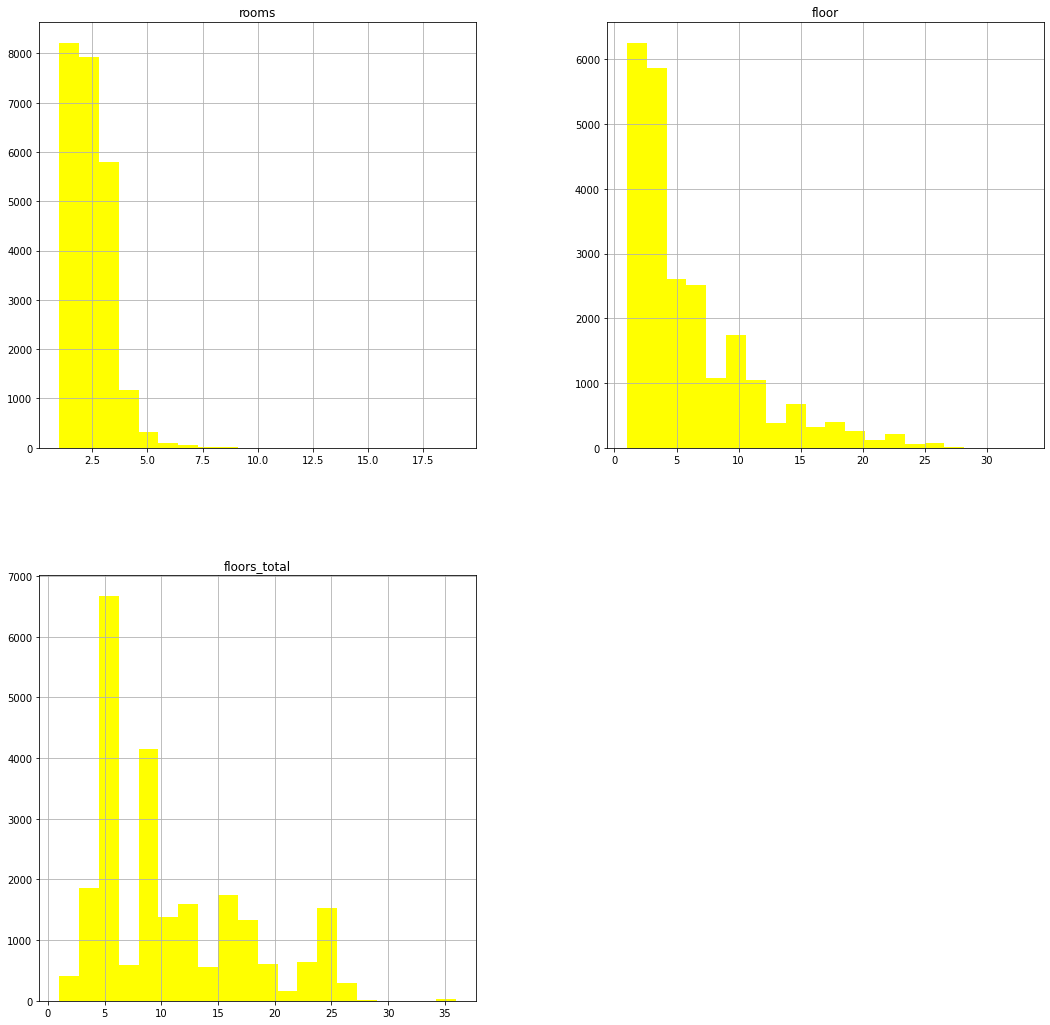

In [33]:
data[['rooms', 'floor', 'floors_total']].hist(figsize=(18, 18), color = 'yellow', bins = 20) ;

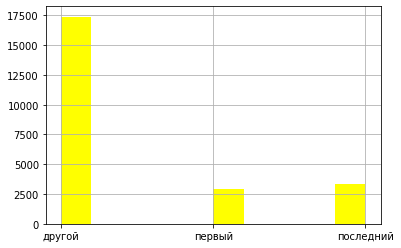

In [34]:
data[ 'floor_type'].hist(color = 'yellow') ;#всего 3 значения, поэтому отдельно

Видно, что больше всего 1/2/3-комнатных квартир, самые распространенные этажи - низкие, что может объясняться тем, что значительная часть домов пятиэтажные. На графике с этажами в доме можно заметить пики на типовых значениях - 5, 9, 16. Первых и последних этажей ожидаемо меньше, чем остальных.

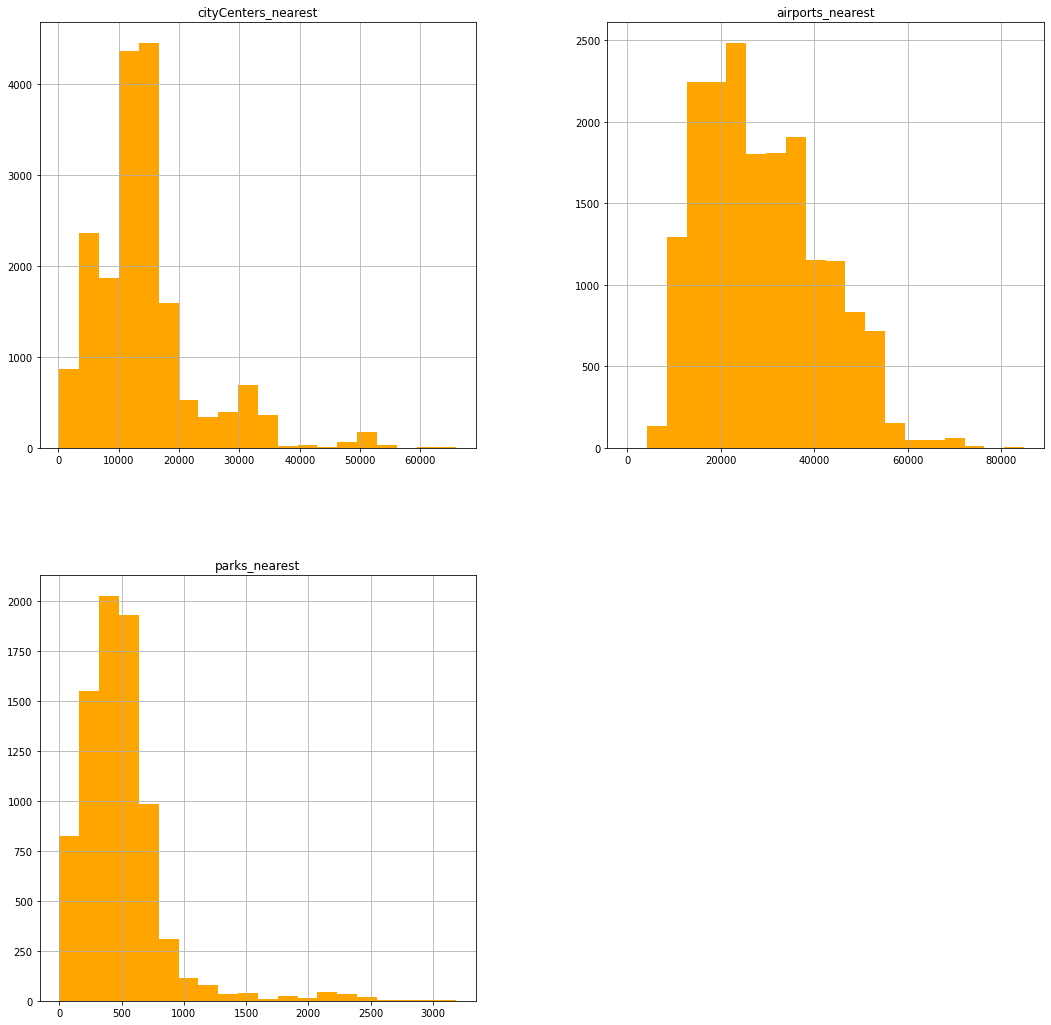

In [35]:
data[['cityCenters_nearest', 'airports_nearest', 'parks_nearest']].hist(figsize=(18, 18), color = 'orange', bins = 20) ;

Распределение в расстояниях ближе к нормальному. Возможно, это вызвано тем, что значения здесь имеют больший диапазон.

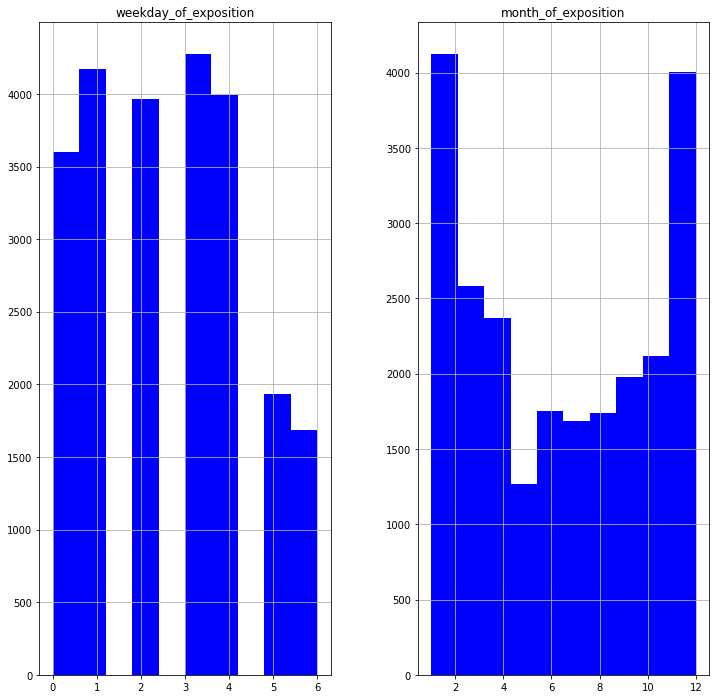

In [36]:
data[['weekday_of_exposition', 'month_of_exposition']].hist(figsize=(12, 12), color = 'blue') ;

По графикам дней и месяцев можно увидеть, что люди реже публикуют объявления в выходные, а также, что летом публикуется меньше объявлений, чем зимой.

#### Изучение сроков продажи

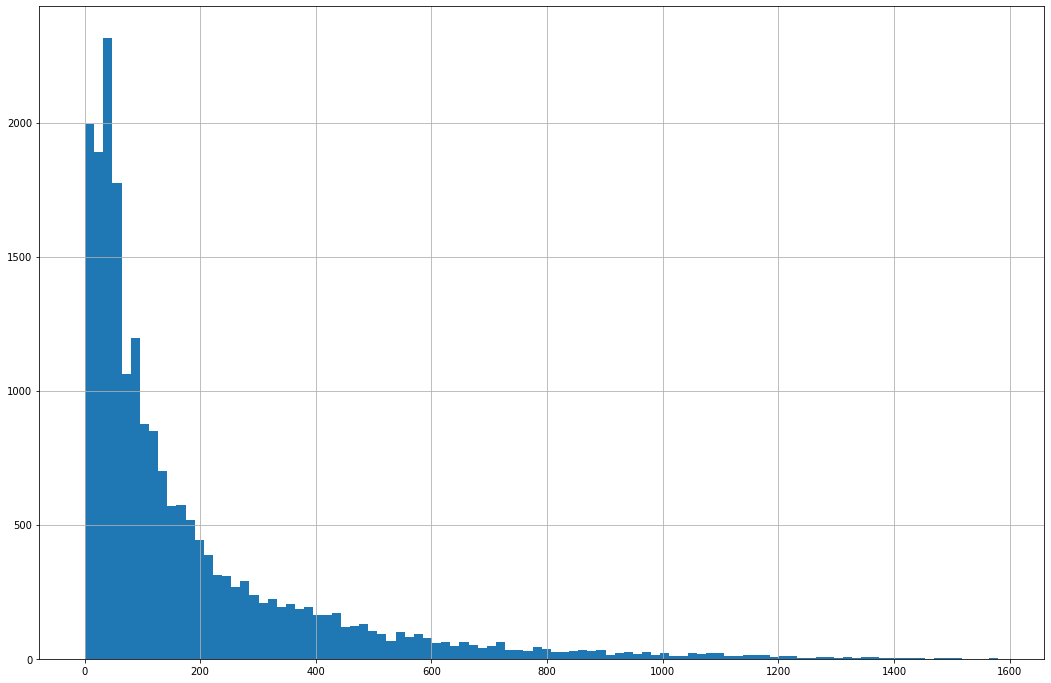

In [37]:
data['days_exposition'].hist(bins = 100, figsize = (18,12));
#при количестве корзин 30 распределение похоже на Парето, поэтому возьмем больше

count    20448.000000
mean       180.841403
std        219.858339
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Дольше 3 лет продавалось 166 квартир
Менее 3 месяцев продавалось 9701 квартир
Менее 1 недели продавалось 611 квартиры


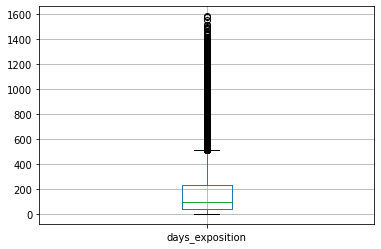

In [38]:
data.boxplot(column ='days_exposition')
display(data['days_exposition'].describe())
print('Дольше 3 лет продавалось {} квартир'.format(data[data['days_exposition']>1095]['total_area'].count()))
print('Менее 3 месяцев продавалось {} квартир'.format(data[data['days_exposition']<90]['total_area'].count()))#примерно медиана
print('Менее 1 недели продавалось {} квартиры'.format(data[data['days_exposition']<7]['total_area'].count()))

Среднее значение 180 дней, медиана 95. Значит, есть небольшое количество очень высоких значений. Для границ возьмем количество дней, соответствующее целым значениям недель/месяцев/лет, людьми так привычнее воспринимается время. Скажем, что "долго" для продажи квартиры это 3 года (1095 дней), только 166 объявлений провисели дольше этого срока, это менее 1 процента от общего количества. "Обычный" срок продажи - 3 месяца, примерно там и проходит медиана. Найти покупателя менее, чем за неделю, удалось 613 продавцам.

#### Влияние параметров на общую стоимость объекта

Рассмотрим влияние различных параметров на стоимость квартир.

Начнем с площадей: общей, жилой и площади кухни. Ограничим графики по стоимости (30 млн.руб.), общей площади (200 кв.м.), жилой площади (100 кв.м.) и площади кухни (50 кв.м.) для удобства восприятия. Крайние точки вписываются в логику, и коэффициент корреляции считаем с их учетом, но смотреть на график становится сложнее.
Все три площади положительно коррелируют с ценой.

Корреляция между ценой и площадью - 0.65


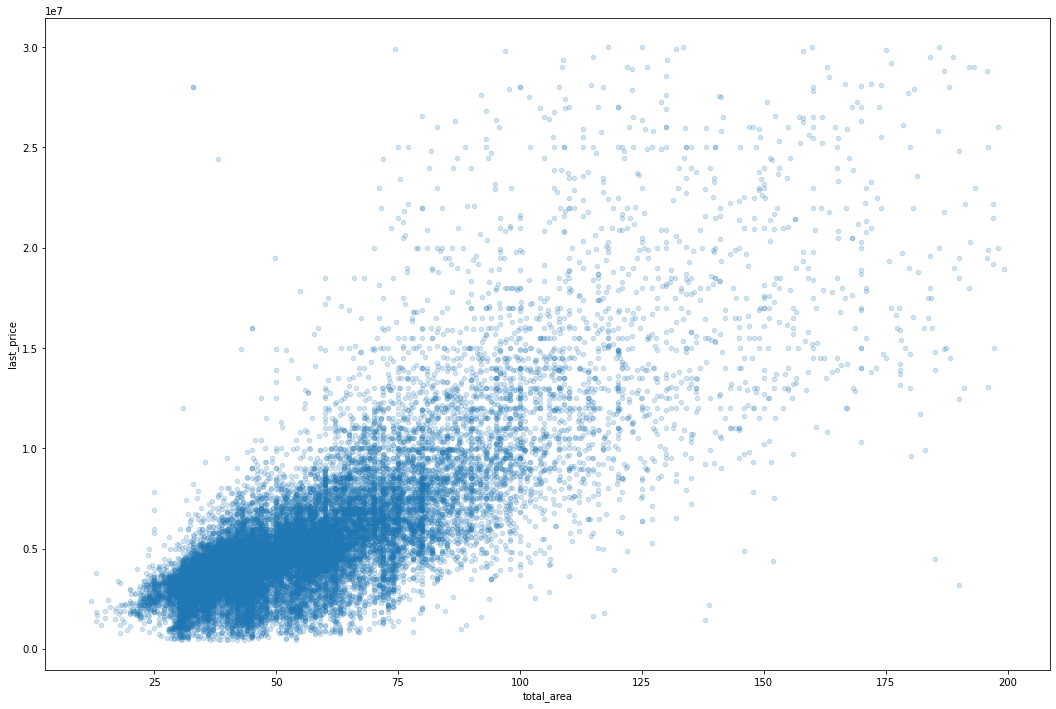

In [39]:
data.query('last_price < 30000000 and total_area < 200').plot(x='total_area', 
                                                               y='last_price', kind='scatter', figsize = (18,12), alpha = 0.2)
print('Корреляция между ценой и площадью -', data['last_price'].corr(data['total_area']).round(2))

Корреляция между ценой и жилой площадью - 0.59


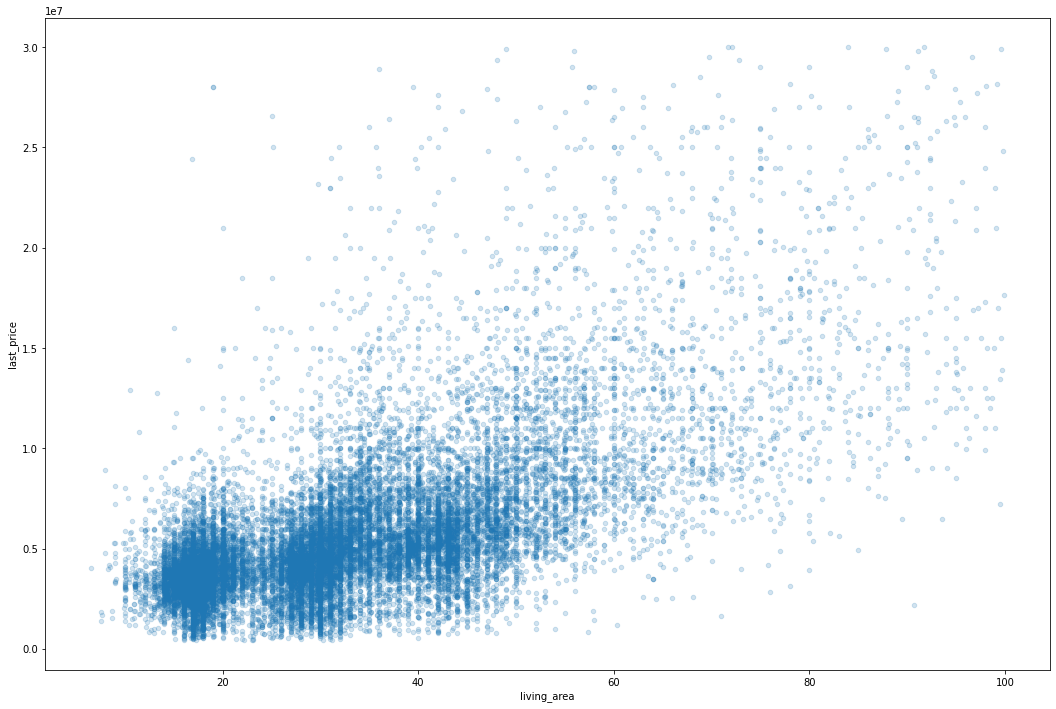

In [40]:
data.query('last_price < 30000000 and living_area < 100').plot(x='living_area', 
                                                               y='last_price', kind='scatter', figsize = (18,12), alpha = 0.2)
print('Корреляция между ценой и жилой площадью -', data['last_price'].corr(data['living_area']).round(2))

Корреляция между ценой и площадью кухни - 0.51


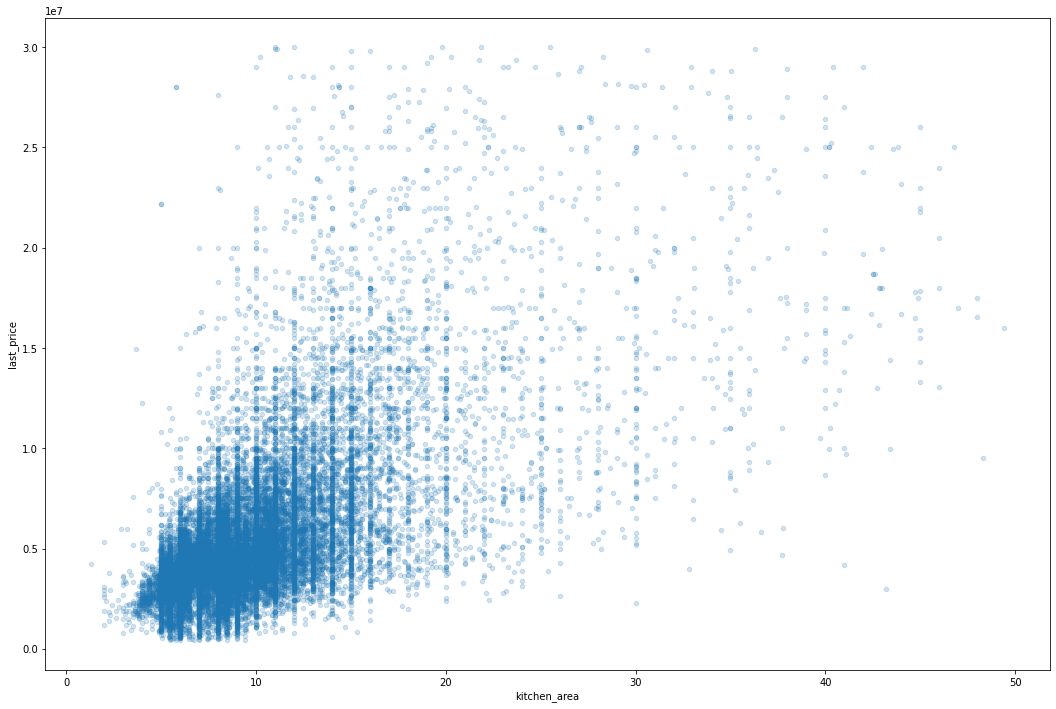

In [41]:
data.query('last_price < 30000000 and kitchen_area < 50').plot(x='kitchen_area', 
                                                               y='last_price', kind='scatter', figsize = (18,12), alpha = 0.2)
print('Корреляция между ценой и площадью кухни -', data['last_price'].corr(data['kitchen_area']).round(2))

Посмотрим, как количество комнат влияет на цену. График типа scatter тут не очень информативен, поэтому сначала сгруппируем квартиры по количеству комнат. Видна небольшая положительная корреляция при количестве комнат до 8; потом начинаются странные скачки, что может быть вызвано уникальностью очень многокомнатных квартир. Если строить график только для квартир с количеством комнат 1-7, можно увидеть четкую положительную корреляцию.

Корреляция между ценой и количеством комнат (для квартир с количеством комнат менее 8) - 0.35


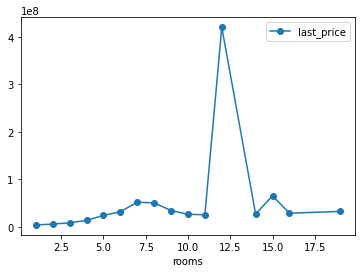

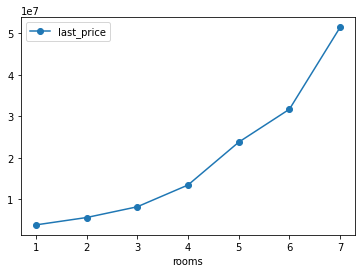

In [42]:
#сгруппируем квартиры по количеству комнат
data.pivot_table(index = 'rooms', values = 'last_price').plot(marker='o');

#построим график отдельно для квартир с количеством комнат менее 8
data[data['rooms']<8].pivot_table(index = 'rooms', values = 'last_price').plot(marker='o');

print('Корреляция между ценой и количеством комнат (для квартир с количеством комнат менее 8) -',
     data[data['rooms']<8]['last_price'].corr(data[data['rooms']<8]['rooms']).round(2))

Рассмотрим влияние типа этажа на стоимость. Сгруппируем квартиры по типу этажа и построим график. Если рассматривать все данные, то получается, что самые дорогие - квартиры на последнем этаже. Возможно, дорогие последние этажи - пентхаусы, и "последнесть" этажа у них это фишка, а не баг. Судя по средней стоимости, основная масса объектов - не элитные пентхаусы. Если ограничить стоимость до 30 млн.руб, то средние этажи окажутся дороже.

Средняя стоимость квартиры - 6541327.0


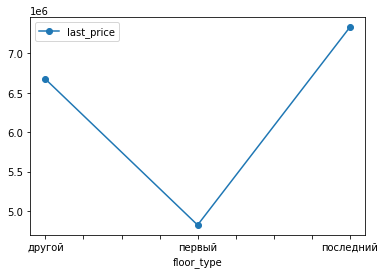

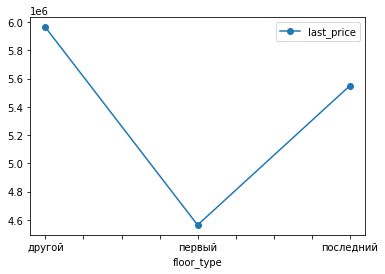

In [43]:
#сгруппируем квартиры по типу этажа и построим график
data.pivot_table(index = 'floor_type', values = 'last_price').plot(marker='o');

print('Средняя стоимость квартиры -', data['last_price'].mean().round())

#тот же график, но с ограничением по цене 30млн
data.query('last_price < 30000000').pivot_table(index = 'floor_type', values = 'last_price').plot(marker='o');

Рассмотрим влияние даты размещения на цену. Сгруппируем квартиры по дню, месяцу и году размещения объявления. По дню и месяцу может показаться, что зависимость есть, но размах значений в 700тыс. рублей не так уж велик на фоне абсолютных значений. По году видна тенденция к снижению до 2018 года, потом рост. Перестроим те же графики с масштабом стоимости от 3 до 30 млн. Различия по дням и месяцам практически незаметны, а вот различия по годам остаются значительными.

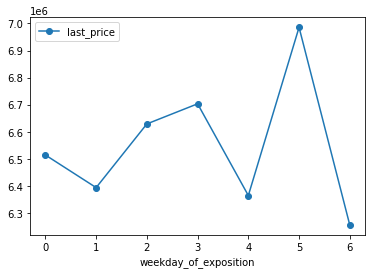

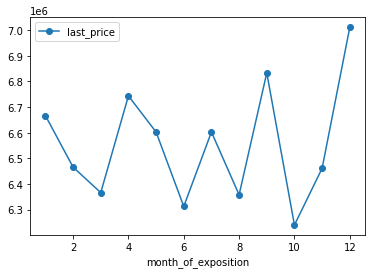

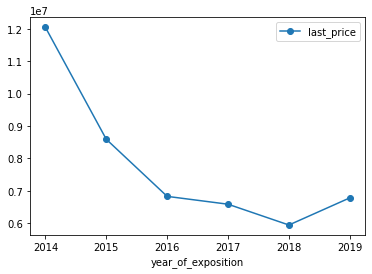

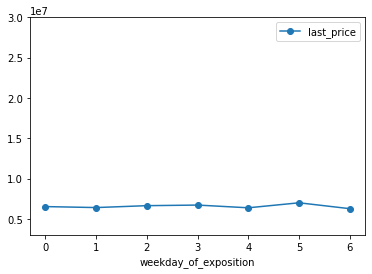

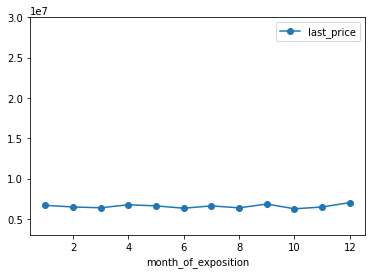

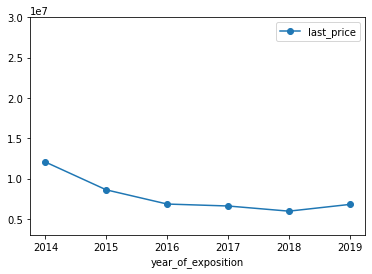

In [44]:
#сгруппируем квартиры по дню недели, месяцу и году размещения
data.pivot_table(index = 'weekday_of_exposition', values = 'last_price').plot(marker='o');
data.pivot_table(index = 'month_of_exposition', values = 'last_price').plot(marker='o');
data.pivot_table(index = 'year_of_exposition', values = 'last_price').plot(marker='o');

#ограничим цену от 3 до 30 млн 
data.pivot_table(index = 'weekday_of_exposition', values = 'last_price').plot(marker='o', ylim = (3000000, 30000000));
data.pivot_table(index = 'month_of_exposition', values = 'last_price').plot(marker='o', ylim = (3000000, 30000000));
data.pivot_table(index = 'year_of_exposition', values = 'last_price').plot(marker='o', ylim = (3000000, 30000000));

Вывод: стоимость положительно коррелирует со всеми видами площадей (выше всего - с общей) и количеством комнат (если их меньше 8). Квартиры на средних этажах в среднем стоят на 1.5 млн больше, чем на первом, и, если не рассматривать верхний ценовой сегмент (от 30 млн), то на 0.5 млн больше, чем на последнем. На стоимость не влияют день и месяц публикации объявления, а вот по годам средняя стоимость менялась: постепенный спад, минимум в 2018 году, потом в 2019 рост до уровня 2016-17гг.

#### Средняя цена квадратного метра

Найдем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [45]:
data['locality_name'].value_counts().head(10)

top_ten = data.groupby('locality_name')['price_per_sq_meter'].agg(['count', 'mean']).sort_values(by = 'count',
                                                                                                ascending = False).head(10)
display(top_ten)

print('Самая высокая средняя стоимость квадратного метра {} р/кв.м'.format(top_ten['mean'].max().round(1))) 
print('Самая низкая средняя стоимость квадратного метра {} р/кв.м'.format(top_ten['mean'].min().round(1)))

,count,mean
locality_name,,
Санкт-Петербург,15707,114825.458494
поселок Мурино,556,85681.762601
поселок Шушары,440,78677.364217
Всеволожск,397,68719.320400
Пушкин,369,103125.819291
Колпино,338,75424.579098
поселок Парголово,327,90175.913458
Гатчина,307,68746.146763
деревня Кудрово,299,92473.547576


Самая высокая средняя стоимость квадратного метра 114825.5 р/кв.м
Самая низкая средняя стоимость квадратного метра 58238.1 р/кв.м


Самый дорогой квадратный метр жилья - в Санкт-Петербурге, самый дешевый - в Выборге.

#### Стоимость по километрам от центра в Санкт-Петербурге.

<AxesSubplot:xlabel='bins'>

Средняя стоимость километра в тыс.руб.


bins
(-1, 0]     31449.12
(0, 1]      21206.72
(1, 2]      17788.32
(2, 3]      11126.58
(3, 4]      13304.28
(4, 5]      14510.76
(5, 6]      15248.21
(6, 7]      14775.15
(7, 8]       9945.31
(8, 9]       6971.19
(9, 10]      6504.12
(10, 11]     6251.33
(11, 12]     5832.61
(12, 13]     6084.68
(13, 14]     5628.83
(14, 15]     5884.23
(15, 16]     5373.13
(16, 17]     5292.39
(17, 18]     5091.33
(18, 19]     5037.67
(19, 20]     5990.04
(20, 21]     5493.47
(21, 22]     5415.52
(22, 23]     4985.38
(23, 24]     3854.43
(24, 25]     4052.84
(25, 26]     3973.01
(26, 27]     8300.00
(27, 28]     5026.43
(28, 29]     4236.67
Name: last_price, dtype: float64

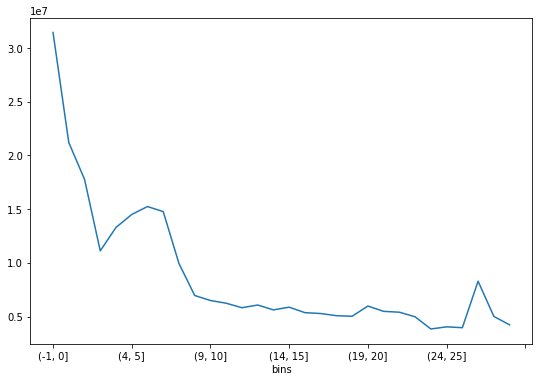

In [46]:
flats_SPb = data[data['locality_name']=='Санкт-Петербург'].reset_index(drop = True)
#flats_SPb['cityCenters_nearest_km'].hist()#чтобы понять диапазон

cut_bins = [i for i in range (-1,30)]#разбиение по километрам
flats_SPb['bins'] = pd.cut(flats_SPb['cityCenters_nearest_km'], bins = cut_bins)

display(flats_SPb.groupby('bins')['last_price'].mean().plot(figsize = (9,6)))
print('Средняя стоимость километра в тыс.руб.')
(flats_SPb.groupby('bins')['last_price'].mean()/1000).round(2)

<AxesSubplot:xlabel='cityCenters_nearest_km'>

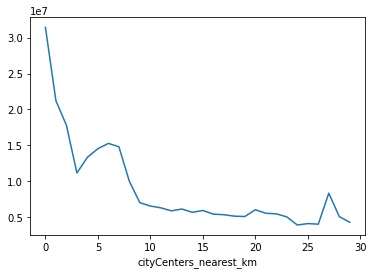

In [49]:
flats_SPb.groupby('cityCenters_nearest_km')['last_price'].mean().plot()

На перестроенном графике стал более заметен провал в районе 3 км. В таблице снизу видно, что этот провал вызван тем, что на этом километре ниже средняя площадь продаваемых квартир, потом к 5 она снова возрастает вместе со средней стоимостью.

In [48]:
flats_SPb.pivot_table(index = 'cityCenters_nearest_km', values = ['total_area',]).head(10)

,total_area
cityCenters_nearest_km,
0.0,117.259259
1.0,104.999896
2.0,102.504000
3.0,90.273429
4.0,91.475494
5.0,95.957791
6.0,90.331459
7.0,82.058762
8.0,73.602908


Стоимость объектов, в целом, снижается с удалением от центра. Если рассматривать этот график вместе с картой города, можно объяснить два падения на графике: первый около 3 км, видимо, там заканчивается непосредственно центр города, а второй около 9 км, за которым уже окраина. Подъемы у правого края  - это уже Ленинградская область, в которой есть свои города-спутники, а в них - дорогие новостройки.

### Общий вывод

В проекте был рассмотрен архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. В данных было достаточно много пропусков, которые могли быть вызваны как техническими проблемами, так и человеческим фактором.

Сделано следующее:
1. Выполнена предобработка данных, в рамках которой были по возможности заполнены пропуски и исправлены явно ошибочные данные.
2. Добавлены новые столбцы, рассчитанные на основе имеющейся информации.
3. Проведен исследовательский анализ различных параметров. Площади варьируются от 12 до 900 кв.м, цены - от 430 тыс.руб. до 763 млн.руб. Преобладающий вид квартир - 1/2/3-комнатные, на низких этажах, площадью 50-60 кв.м, стоимостью 6-10 млн.руб. 
4. Изучена длительность продажи квартир. В среднем, квартиры продаются за 3 месяца, но в редких случаях срок продажи может быть и 1 неделя, и 3 года.
5. Исследовано влияние различных факторов на стоимость объекта. Цены выше у квартир большой площади, рядом с центром, этаж - не первый/не последний, с большим, но не слишком (не более 7) количеством комнат.
6. Рассчитана средняя цена одного квадратного метра в 10 населенных пунктах с наибольшим количеством объявлений, выявлены наибольшая - 114818.3 р/кв.м (ожидаемо в Санкт-Петербурге) и наименьшая - 58238.1 р/кв.м (в Выборге).
7. Рассчитана средняя стоимость квартир в Санкт-Петербурге по каждому километру расстояния от центра. Центр города имеет радиус около 3 км, там стоимость квартир наибольшая.

В анализе была бы полезна дополнительная информация: год постройки дома, статус дома (сдан/не сдан), материал стен дома, категория ремонта (без отделки/косметический/капитальный), тип и количество санузлов.